# Mole image classifier
#### Using Tensroflow 2.0 and Keras



In [0]:
!pip install -q kaggle
!pip install tensorflow==2.1.0

#### Download Skin Cancer MNIST: HAM10000 dataset from Kaggle

Instructions for kaggle API here: https://github.com/Kaggle/kaggle-api

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip skin-cancer-mnist-ham10000.zip

In [0]:
import os
import random
import pandas as pd
import numpy as np
from shutil import copyfile, move
from datetime import datetime

from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [0]:
tf.__version__

'2.1.0'

#### Brifely explore dataset

In [0]:
metadata = pd.read_csv('HAM10000_metadata.csv')
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


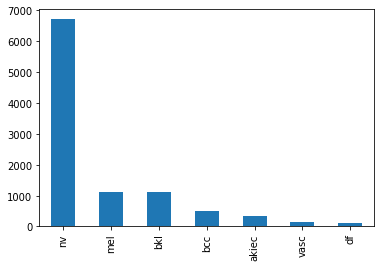

In [0]:
metadata['dx'].value_counts().plot(kind='bar')

Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (followup), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). The dataset includes lesions with multiple images, which can be tracked by the lesionid-column within the HAM10000_metadata file.

#### Organise images into train, valid and test folders

In [0]:
lesion_types = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [0]:
# create folders for train, validation and test sets
os.mkdir('data')

for dataset in ['train', 'valid', 'test']:
  os.mkdir(f'data/{dataset}')
  for lesion_type in lesion_types:
    os.mkdir(f'data/{dataset}/{lesion_type}')

In [0]:
# move all images to relevant train folder
for index, row in metadata.iterrows():
  try:
    src = f'HAM10000_images_part_1/{row["image_id"]}.jpg'
    dst = f'data/train/{row["dx"]}/{row["image_id"]}.jpg'
    copyfile(src, dst)
  except FileNotFoundError:
    src = f'HAM10000_images_part_2/{row["image_id"]}.jpg'
    dst = f'data/train/{row["dx"]}/{row["image_id"]}.jpg'
    copyfile(src, dst)

In [0]:
# sample balanced valid and test sets
for lesion in lesion_types:
  train_path = f'data/train/{lesion}/'
  valid_path = f'data/valid/{lesion}/'
  test_path = f'data/test/{lesion}/'

  print(f'Creating {lesion} valid and test dataset...')

  files = os.listdir(train_path)
  num_files = len(files)

  print(f'Number of images for lesion: {num_files}')

  # portion = 0.1
  # k = int(num_files * portion)
  k = 30

  file_array = np.array(files)
  np.random.shuffle(file_array)
  valid_files = file_array[0:k]
  test_files = file_array[k + 1: 2*k]

  for f in valid_files:
    move(train_path + f, valid_path)
  
  for f in test_files:
    move(train_path + f, test_path)

Creating akiec valid and test dataset...
Number of images for lesion: 268
Creating bcc valid and test dataset...
Number of images for lesion: 455
Creating bkl valid and test dataset...
Number of images for lesion: 1040
Creating df valid and test dataset...
Number of images for lesion: 56
Creating mel valid and test dataset...
Number of images for lesion: 1054
Creating nv valid and test dataset...
Number of images for lesion: 6646
Creating vasc valid and test dataset...
Number of images for lesion: 83


In [0]:
# remove unused folders and files
!rm -rf HAM10000_images_part_1/
!rm -rf HAM10000_images_part_2/
!rm -rf ham10000_images_part_1/
!rm -rf ham10000_images_part_2/
!rm -rf sample_data/
!rm hmnist_28_28_L.csv
!rm hmnist_28_28_RGB.csv
!rm hmnist_8_8_RGB.csv
!rm hmnist_8_8_L.csv
!rm skin-cancer-mnist-ham10000.zip

#### Inspect created train, valid and test sets

In [0]:
PATH = 'data'
train_dir = os.path.join(PATH, 'train')
valid_dir = os.path.join(PATH, 'valid')
test_dir = os.path.join(PATH, 'test')

train_dirs = {}
valid_dirs = {}
test_dirs = {}
for lesion in lesion_types:
  train_dirs[lesion] = os.path.join(train_dir, lesion)
  valid_dirs[lesion] = os.path.join(valid_dir, lesion)
  test_dirs[lesion] = os.path.join(test_dir, lesion)

In [0]:
num_tr = {}
num_val = {}
num_test = {}
for lesion in lesion_types:
  num_tr[lesion] = len(os.listdir(train_dirs[lesion]))
  num_val[lesion] = len(os.listdir(valid_dirs[lesion]))
  num_test[lesion] = len(os.listdir(test_dirs[lesion]))

total_train = sum(num_tr.values())
total_val = sum(num_val.values())
total_test = sum(num_test.values())

In [0]:
for lesion in lesion_types: 
  print(f'total training {lesion} images:', num_tr[lesion])
  print(f'total validation {lesion} images:', num_val[lesion])
  print(f'total test {lesion} images:', num_test[lesion])
  print('---')

print('---')
print("Total training images:", total_train)
print("Total validation images:", total_val)
print("Total test images:", total_test)

total training akiec images: 209
total validation akiec images: 60
total test akiec images: 58
---
total training bcc images: 396
total validation bcc images: 60
total test bcc images: 58
---
total training bkl images: 981
total validation bkl images: 60
total test bkl images: 58
---
total training df images: 1
total validation df images: 60
total test df images: 54
---
total training mel images: 995
total validation mel images: 60
total test mel images: 58
---
total training nv images: 6587
total validation nv images: 60
total test nv images: 58
---
total training vasc images: 24
total validation vasc images: 60
total test vasc images: 58
---
---
Total training images: 9193
Total validation images: 420
Total test images: 402


#### Prepare images using ImageGenerator from Keras

In [0]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [0]:
train_image_generator = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=45,
                            width_shift_range=.15,
                            height_shift_range=.15,
                            horizontal_flip=True,
                            zoom_range=0.5)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [0]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical',
                                                           classes=lesion_types)

Found 9193 images belonging to 7 classes.


In [0]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=valid_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical',
                                                              classes=lesion_types)

Found 420 images belonging to 7 classes.


In [0]:
sample_training_images, _ = next(train_data_gen)

In [0]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

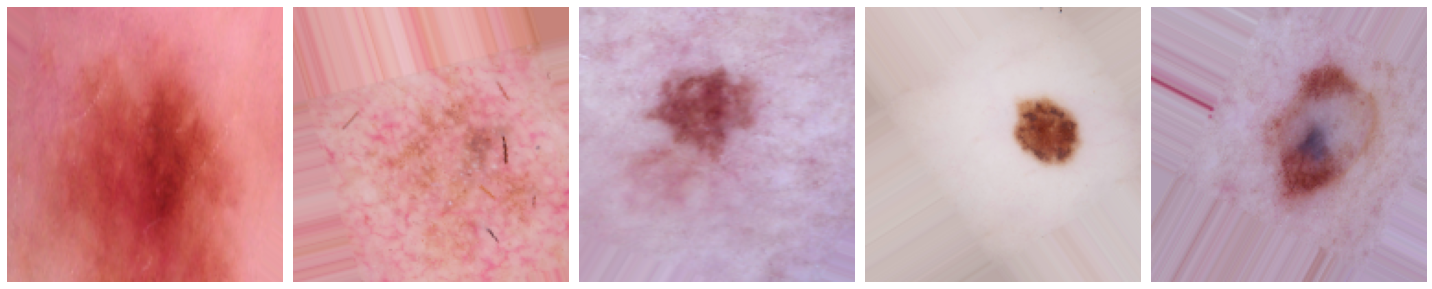

In [0]:
plotImages(sample_training_images[:5])

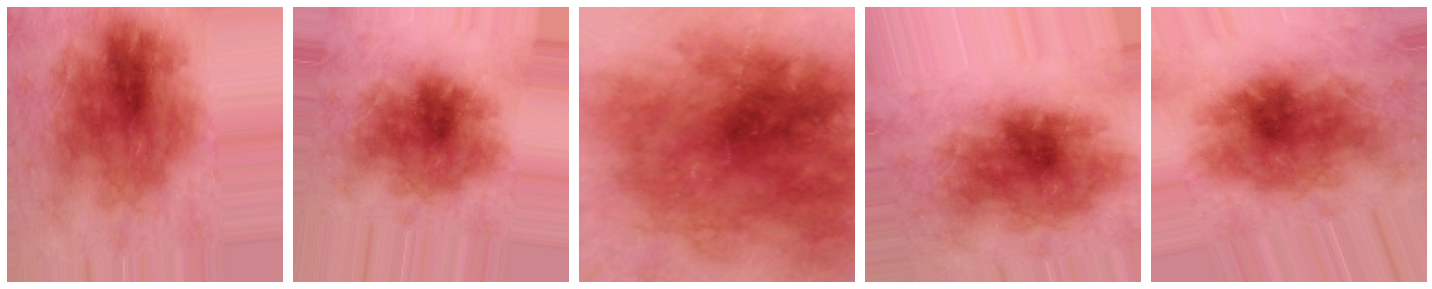

In [0]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### Create wheights for classes

In [0]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
class_weight = {}
for index, lesion in enumerate(lesion_types): 
  weight = (1 / num_tr[lesion])*(total_train / 2.0)
  class_weight[index] = weight

  print(f'Weight for class {index}, {lesion}: {weight}')

Weight for class 0, akiec: 21.992822966507177
Weight for class 1, bcc: 11.607323232323234
Weight for class 2, bkl: 4.6855249745158005
Weight for class 3, df: 4596.5
Weight for class 4, mel: 4.6195979899497495
Weight for class 5, nv: 0.6978138758160012
Weight for class 6, vasc: 191.52083333333331


#### Build Sequential model

In [0]:
# options: inception, vgg, resnet, densenet, custom
model_type = 'inception'
num_classes = 7

In [0]:
if model_type == 'custom':
  model = Sequential([
      Conv2D(16, 3, padding='same', activation='relu', 
            input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
      MaxPooling2D(),
      Dropout(0.2),
      Conv2D(32, 3, padding='same', activation='relu'),
      MaxPooling2D(),
      Conv2D(64, 3, padding='same', activation='relu'),
      MaxPooling2D(),
      Dropout(0.2),
      Flatten(),
      Dense(512, activation='relu'),
      Dense(num_classes)
  ])

In [0]:
if model_type == 'inception':
  base_model = tf.keras.applications.InceptionV3(weights='imagenet', 
                                                 include_top=False, 
                                                 input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

  # add a global spatial average pooling layer
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation='relu')(x)
  predictions = Dense(num_classes, activation='softmax')(x)

  model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

  # first: train only the top layers (which were randomly initialized)
  # i.e. freeze all convolutional InceptionV3 layers
  for layer in base_model.layers:
    layer.trainable = False

In [0]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_194 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 74, 74, 32)   96          conv2d_194[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 74, 74, 32)   0           batch_normalization_188[0][0]    
______________________________________________________________________________________________

#### Train and evaluate model

In [0]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=2,
    mode='max',
    restore_best_weights=True)

In [0]:
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    callbacks = [early_stopping],
    class_weight=class_weight
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 71 steps, validate for 3 steps
Epoch 1/15
71/71 [==============================] - 127s 2s/step - loss: 6.8980 - accuracy: 0.3422 - val_loss: 1515.7066 - val_accuracy: 0.1432
Epoch 2/15
71/71 [==============================] - 121s 2s/step - loss: 6.7745 - accuracy: 0.4546 - val_loss: 1521.0785 - val_accuracy: 0.1458
Epoch 3/15
71/71 [==============================] - 122s 2s/step - loss: 6.7304 - accuracy: 0.5614 - val_loss: 1519.1174 - val_accuracy: 0.1667
Epoch 4/15
71/71 [==============================] - 122s 2s/step - loss: 6.6673 - accuracy: 0.6040 - val_loss: 1516.9256 - val_accuracy: 0.1797
Epoch 5/15
71/71 [==============================] - 122s 2s/step - loss: 6.6112 - accuracy: 0.6026 - val_loss: 1520.0808 - val_accuracy: 0.1562
Epoch 6/15
71/71 [==============================] - 122s 2s/step - loss: 6.7745 - accuracy: 0.6106 - val_loss: 1514.2702 - val_accuracy: 0.2448
Epoch 7/15
71/71 [===========================

In [0]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9), 
              loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    callbacks = [early_stopping],
    class_weight=class_weight
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 71 steps, validate for 3 steps
Epoch 1/15
71/71 [==============================] - 125s 2s/step - loss: 52.8024 - accuracy: 0.2707 - val_loss: 91887.9792 - val_accuracy: 0.1484
Epoch 2/15
71/71 [==============================] - 120s 2s/step - loss: 12.8147 - accuracy: 0.4473 - val_loss: 4406.0851 - val_accuracy: 0.1797
Epoch 3/15
71/71 [==============================] - 121s 2s/step - loss: 9.6496 - accuracy: 0.3950 - val_loss: 5397.9403 - val_accuracy: 0.1849
Epoch 4/15
71/71 [==============================] - 120s 2s/step - loss: 6.7566 - accuracy: 0.5130 - val_loss: 5463.1045 - val_accuracy: 0.1536
Epoch 5/15
71/71 [==============================] - 120s 2s/step - loss: 10.1176 - accuracy: 0.2966 - val_loss: 3574.6576 - val_accuracy: 0.1901
Epoch 6/15
71/71 [==============================] - 121s 2s/step - loss: 6.9326 - accuracy: 0.4266 - val_loss: 4688.2684 - val_accuracy: 0.1953
Epoch 7/15
71/71 [=======================

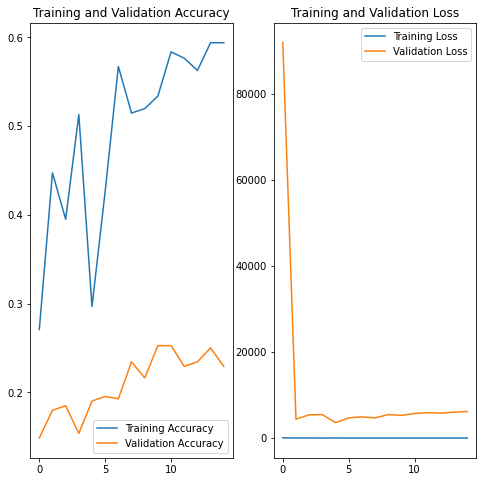

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)
epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Evaluate and make predcitions on validation set

In [0]:
test_image_generator = ImageDataGenerator(rescale=1./255)

test_data_gen = test_image_generator.flow_from_directory(batch_size=1,
                                                         directory=valid_dir,
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         class_mode='categorical',
                                                         classes=lesion_types)

Found 420 images belonging to 7 classes.


In [0]:
evaluation = model.evaluate_generator(test_data_gen, 
                                      steps=total_val)

test_data_gen.reset()
prediction = model.predict_generator(test_data_gen, 
                                     steps=total_val)

print(f'Validation loss: {evaluation[0]}')
print(f'Validation accuracy: {evaluation[1]}')

  ...
    to  
  ['...']
Validation loss: 4.89323057815533
Validation accuracy: 0.22857142984867096


In [0]:
print('Classification Report - Validation set')

predicted_class_indices = np.argmax(prediction, axis=1)
print(classification_report(test_data_gen.classes, predicted_class_indices, target_names=lesion_types))

Classification Report - Validation set
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        60
         bcc       0.09      0.13      0.11        60
         bkl       0.00      0.00      0.00        60
          df       0.50      0.03      0.06        60
         mel       0.08      0.03      0.05        60
          nv       0.16      0.70      0.26        60
        vasc       0.15      0.08      0.11        60

    accuracy                           0.14       420
   macro avg       0.14      0.14      0.08       420
weighted avg       0.14      0.14      0.08       420



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
def plot_cm(labels, predictions):
  cm = confusion_matrix(labels, predictions, lesion_types)
  plt.figure(figsize=(5,5))
  ax = sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix\n')
  ax.set_xticklabels(lesion_types)
  ax.set_yticklabels(lesion_types) 
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

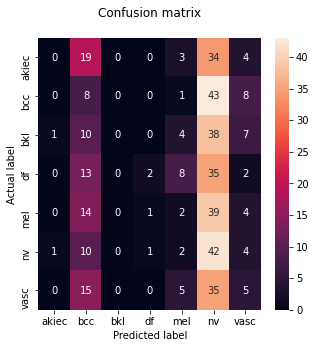

In [0]:
labels = (train_data_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())

predictions = [labels[k] for k in predicted_class_indices]

filenames = test_data_gen.filenames
results = pd.DataFrame({"true": [filename.split('/')[0] for filename in filenames],
                        "pred": predictions})
plot_cm(results['true'], results['pred'])

In [0]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [0]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

#### Save the entire model as a SavedModel



In [0]:
!mkdir -p saved_model

dt_now = datetime.now().strftime("%d%m%Y_%H%M%S")
model.save(f'saved_model/mole_classifier_{dt_now}')

In [0]:
# my_model directory
!ls saved_model

In [0]:
# to load model from SavedModel
new_model = tf.keras.models.load_model('saved_model/mole_classifier')